<a href="https://colab.research.google.com/github/BenjamTorr/TDA_DeepL_TimeSeries/blob/main/classification_of_SonyAI_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importar datos


In [1]:
!pip install -U giotto-tda
from scipy.io import arff
import pandas as pd
import numpy as np
def load():
  data_train = arff.loadarff('drive/MyDrive/Data-Time_Series/SonyAIBORobotSurface1_TEST.arff')
  df_train = pd.DataFrame(data_train[0])

  x_train = df_train.to_numpy()
  y_train = x_train[:,-1]
  y_train = [y_train[i][0] - 49 for i in range(len(y_train))]
  y_train = np.transpose(np.array(y_train))

  data_test = arff.loadarff('drive/MyDrive/Data-Time_Series/SonyAIBORobotSurface1_TRAIN.arff')
  df_test = pd.DataFrame(data_test[0])

  x_test = df_test.to_numpy()
  y_test = x_test[:,-1]

  y_test = [y_test[i][0] - 49 for i in range(len(y_test))]
  x_test[1,:-1]

  X_test = [x_test[i,:-1] for i in range(len(x_test))]
  X_train = [x_train[i,:-1] for i in range(len(x_train))]
  return X_train, y_train, X_test, y_test



# Creamos la secuencia de Betti apartir de los datos de disponibles


In [2]:
import gtda
from gtda.time_series import TakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import BettiCurve


def get_betti_seq(X_train, X_test):
  TE = TakensEmbedding(time_delay=1, dimension=3)
  Embd_train = TE.fit_transform(X_train)
  Embd_test = TE.fit_transform(X_test)

  VR_train = VietorisRipsPersistence(homology_dimensions=(0,1,2))
  Xt = VR_train.fit_transform(Embd_train)
  VR_test = VietorisRipsPersistence(homology_dimensions=(0,1,2))
  Xtr = VR_test.fit_transform(Embd_test)

  BC_train = BettiCurve(n_bins = 200)
  X_betti_curves_train = BC_train.fit_transform(Xt)
  BC_test = BettiCurve(n_bins = 200)
  X_betti_curves_test = BC_test.fit_transform(Xtr)

  X_betti_seq_train = [np.concatenate([X_betti_curves_train[i,0], X_betti_curves_train[i,1], X_betti_curves_train[i,2]]) for i in range(len(X_betti_curves_train))]
  X_betti_seq_test = [np.concatenate([X_betti_curves_test[i,0], X_betti_curves_test[i,1], X_betti_curves_test[i,2]]) for i in range(len(X_betti_curves_test))]

  return X_betti_seq_train, X_betti_seq_test

# Preprocesamos datos

In [3]:
X_train, y_train, X_test, y_test = load()
X_betti_seq_train, X_betti_seq_test = get_betti_seq(X_train, X_test)



In [4]:
X_betti_seq_val = np.array(X_betti_seq_train[:50])
X_betti_seq_trainR = np.array(X_betti_seq_train[50:])
y_val = np.array(y_train[:50])
y_trainR = np.array(y_train[50:])
X_betti_seq_val.shape

X_betti_seq_val = np.expand_dims(X_betti_seq_val, axis=-1)
X_betti_seq_trainR = np.expand_dims(X_betti_seq_trainR, axis=-1)

X_betti_seq_testR = np.array(X_betti_seq_test)
y_testR = np.array(y_test)
X_betti_seq_testR = np.expand_dims(X_betti_seq_test, axis=-1)

(551, 600, 1)

# Creamos el modelo de la red Neuronal

In [19]:
import tensorflow as tf
from tensorflow import keras
def evaluar_modelo(X_betti_seq_train, y_train, X_betti_seq_test, y_test, X_betti_seq_val, y_val, verbose1):
  model = keras.models.Sequential([
      keras.layers.Conv1D(32, 5, activation="relu", padding="same", input_shape=(600, 1)),
      keras.layers.Conv1D(32, 3, activation="relu", padding="same"),
      keras.layers.Dropout(0.5),
      keras.layers.MaxPooling1D(2, padding="same"),
      keras.layers.Flatten(),
      keras.layers.Dense(100, activation="relu"),
      keras.layers.Dense(2, activation="softmax")
  ])
  model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  #history = model.fit(X_betti_seq_train, y_train, epochs=50, validation_data=(X_betti_seq_val, y_val), verbose = verbose1)
  #a,acc = model.evaluate(X_betti_seq_test, y_test)
  history = model.fit(X_betti_seq_train, y_train, epochs=50, validation_data=(X_betti_seq_test, y_test), verbose = verbose1)
  a,acc = model.evaluate(X_betti_seq_val, y_val)
  return history, acc, model

In [20]:
y_tes = keras.utils.to_categorical(y_testR)
y_tra = keras.utils.to_categorical(y_trainR)
y_v = keras.utils.to_categorical(y_val)

In [45]:
history, acc, model = evaluar_modelo(X_betti_seq_trainR, y_tra, X_betti_seq_testR, y_tes, X_betti_seq_val, y_v, 0)
acc

2/2 [==============================] - 0s 11ms/step - loss: 0.3467 - accuracy: 0.9200


0.9200000166893005

# Matriz de confusión de los datos de prueba (50 datos)

In [43]:
y_pred = model.predict(X_betti_seq_val)


In [44]:
import plotly.express as px

CM = tf.math.confusion_matrix(y_pred.argmax(axis=1), y_v.argmax(axis=1))

fig = px.imshow(CM)
fig.show()

<function matplotlib.pyplot.show>

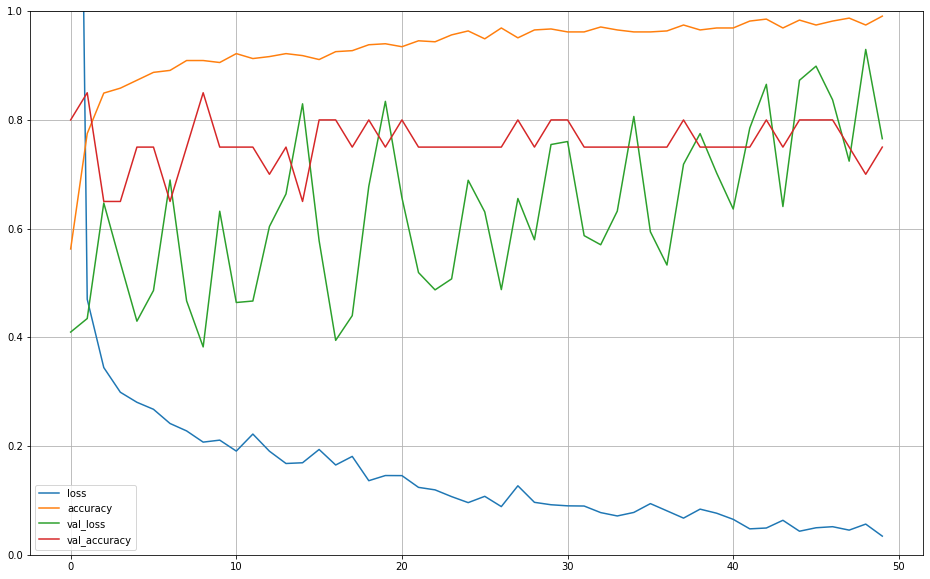

In [29]:
from matplotlib import pyplot as plt
pd.DataFrame(history.history).plot(figsize=(16,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show

# Probamos varias veces

In [27]:
def evaluar():
  scores = []
  for _ in range(10):
    h, acc, modelo = evaluar_modelo(X_betti_seq_trainR, y_tra, X_betti_seq_testR, y_tes, X_betti_seq_val, y_v, 0)
    acc = acc * 100
    scores.append(acc)
  m, s = np.mean(scores), np.std(scores)
  return m, s

In [28]:
m, s = evaluar()
print(m)
print(s)

2/2 [==============================] - 0s 11ms/step - loss: 0.3331 - accuracy: 0.9000
91.39999985694885
1.2806262326190685
